In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import scipy
class wfData:
    '''
    creates all necessary items for working with widefield imaging data
    defines functions for creating various types of videos
    defines functions for creating various types of activity graphs
    '''
    def __init__(self, pathSubject, pathStim):
        '''
        creates all the items
        '''
        serverPath = Path(pathSubject)
        self.timeFile = serverPath / 'cameraFrameTimes.npy'
        self.frameTimes = np.squeeze(np.load(self.timeFile))[::2]
        self.svdTemp = np.load(serverPath / 'corr/svdTemporalComponents_corr.npy')
        self.svdSpatRaw = np.load(serverPath / 'blue/svdSpatialComponents.npy')
        self.svdSpat500 = self.svdSpatRaw[:,:,:500]
        self.meanImage = np.load(serverPath / 'blue/meanImage.npy')
        self.stimOnTimes = np.squeeze(np.load(pathStim / 'linTestOnTimes.npy'))
        self.stimContrasts = np.squeeze(np.load(pathStim / 'linTestContrasts.npy'))
        self.stimDurations = np.squeeze(np.load(pathStim / 'linTestDurations.npy'))
        self.getTempComp = scipy.interpolate.interp1d(self.frameTimes, self.svdTemp, axis=0)
        self.spatial = (self.svdSpat500).reshape(560*560, -1)
        self.contrasts = np.unique(self.stimContrasts)
        self.durations = np.unique(self.stimDurations)
    def getContrasts():
        return self.contrasts
    def getDurations():
        return self.durations
    def trial_timeFunc(self, start, end, step, oneTime=False, loc=-1):
        '''
        creates trial timings for a specified start before time, an end after the time, with a 'step' count of
        time points in between.
        oneTime deliniates if we are creating trial times around one trial (True) or around all trials (False)
        loc is also only used if we are creating trial times around one stimulus (oneTime must be true)
        '''
        self.oneTime = oneTime
        if oneTime==True:
            startTime = self.stimOnTimes[loc] - start
            endTime = self.stimOnTimes[loc] + end
            self.trial_time = np.linspace(startTime, endTime, step)
            self.trial_time = np.array(self.trial_time)
        else:
            self.trial_time = [np.linspace(i-0.1, i+0.4, 100) for i in self.stimOnTimes]
            self.trial_time = np.array(self.trial_time)
        return self.trial_time
    def getTempCompFunc(self, trial_time_input):
        '''
        defines the interpolation function used to return trial activity
        '''
        return self.getTempComp(trial_time_input)
    def trial_activityFunc(self, trial_time_input):
        '''
        uses getTempCompFunc to create trial activity for the desired trial times
        '''
        self.trial_activity = self.getTempCompFunc(trial_time_input)
        self.trial_activity = np.array(self.trial_activity)
        return self.trial_activity
    def createVideo(self, trial_activity):
        '''
        checks if we want to make a video for a single timepoint
        oneTime is created prior in trial_timeFunc if we are creating a video around just one trial 
        '''
        if self.oneTime==False:
            trial_activity_re = np.mean(trial_activity, axis=0)
        else:
            trial_activity_re = trial_activity
        self.video = self.spatial @ trial_activity_re.T
        self.video = (self.video).reshape(560,560,-1)
        return self.video
    def plotBrain(self, rows=1, cols=1, avg=False, figsizeCol=2, figsizeRow=2):
        '''
        creates an image of the brain's activity
        can create any number of images or any sort of grid size
        avg allows us to create a picture of the average activity throughout all wanted trials 
                                                    (deliniated by the size of trial_activity)
        '''
        if avg==True:
            f = plt.figure(figsize=(cols*figsizeCol, rows*figsizeRow))
            avg_trial_activity = np.mean(self.trial_activity, axis=1)
            self.video = np.mean(self.video, axis=2)
            plt.imshow(self.video[:, :], clim = np.percentile(self.video, (2, 99.9)))
            plt.colorbar()
        else:
            f = plt.figure(figsize=(cols*figsizeCol, rows*figsizeRow))
            gs = mpl.gridspec.GridSpec(rows, cols)

            for i in range(rows*cols):
                ax = plt.subplot(gs[i])
                plt.imshow(self.video[:, :, i*2], clim = np.percentile(self.video, (2, 99.9)))
                plt.colorbar()

            f.tight_layout()
    def createContrastVideos(self, start, stop, step):
        '''
        creates videos of pixel values across all contrasts for desired trials (deliniated by trial_time)
        '''
        videos=[]
        for contrast in self.contrasts:
            theseIndexes = np.squeeze(np.argwhere(self.stimContrasts == contrast))

            stim = self.stimOnTimes[theseIndexes]
            self.trial_time = [np.linspace(i-start, i+stop, step) for i in stim]

            trial_activity = self.getTempComp(self.trial_time)

            reshape = np.mean(trial_activity, axis=0)
            video = self.spatial @ reshape.T
            video = video.reshape(560, 560, -1)
            videos.append(video)

        videos = np.array(videos)
        return videos
    def createDurationVideos(self, start, stop, step):
        '''
        creates videos of pixel values across all durations for desired trials
        '''
        videos=[]
        for dur in self.durations:
            theseIndexes = np.squeeze(np.argwhere(self.stimDurations==dur))
            stim = self.stimOnTimes[theseIndexes]
            self.trial_time=[np.linspace(i-start,i+stop,step) for i in stim]
            trial_activity=self.getTempComp(self.trial_time)
            reshape = np.mean(trial_activity,axis=0)
            video=self.spatial @ reshape.T
            video = video.reshape(560,560,-1)
            videos.append(video)
        videos=np.array(videos)
        return videos
    def createConDurVid(self, start, stop, step, durCount):
        '''
        creates videos of pixel values across all contrasts for each separate duration
        '''
        videos = [[] for x in range(durCount)]
        for count,duration in enumerate(self.durations[:durCount]):
            theseIndexesDur = np.squeeze(np.argwhere(self.stimDurations == duration))
            for contrast in self.contrasts:
                theseIndexesCon = np.squeeze(np.argwhere(self.stimContrasts == contrast))
                indexes = np.intersect1d(theseIndexesCon, theseIndexesDur)
                stim = self.stimOnTimes[indexes]
                self.trial_time = [np.linspace(i-start, i+stop, step) for i in stim]

                trial_activity = self.getTempComp(self.trial_time)

                reshape = np.mean(trial_activity, axis=0)
                video = self.spatial @ reshape.T
                video = video.reshape(560, 560, -1)
                videos[count].append(video)
                
        videos = np.array(videos)
        return videos
    def corrections(self, frames):
        '''
        does a df/f calculation for pixel values in a video
        '''
        videoCorr = np.mean(frames, axis=(0, 1))
        minActivity = min(videoCorr)
        if minActivity < 0:
            videoCorr += minActivity*-1
        f0 = np.mean(videoCorr[:6])
        videoCorr = [(x-f0)/(f0+1) for x in videoCorr]
        return np.array(videoCorr)

In [31]:
# all times
wfData_new = wfData(Path(r'Z:\Subjects\AL_0023\2023-05-15\1'), Path(r'Z:\Subjects\AL_0023\2023-05-15\3'))
trial_time_data = wfData_new.trial_timeFunc(-.1, .4, 100)
trial_activity_data = wfData_new.trial_activityFunc(trial_time_data)

In [27]:
wfData_new.svdSpat.shape

(560, 560, 2000)

In [32]:
video = wfData_new.createVideo(trial_activity_data)

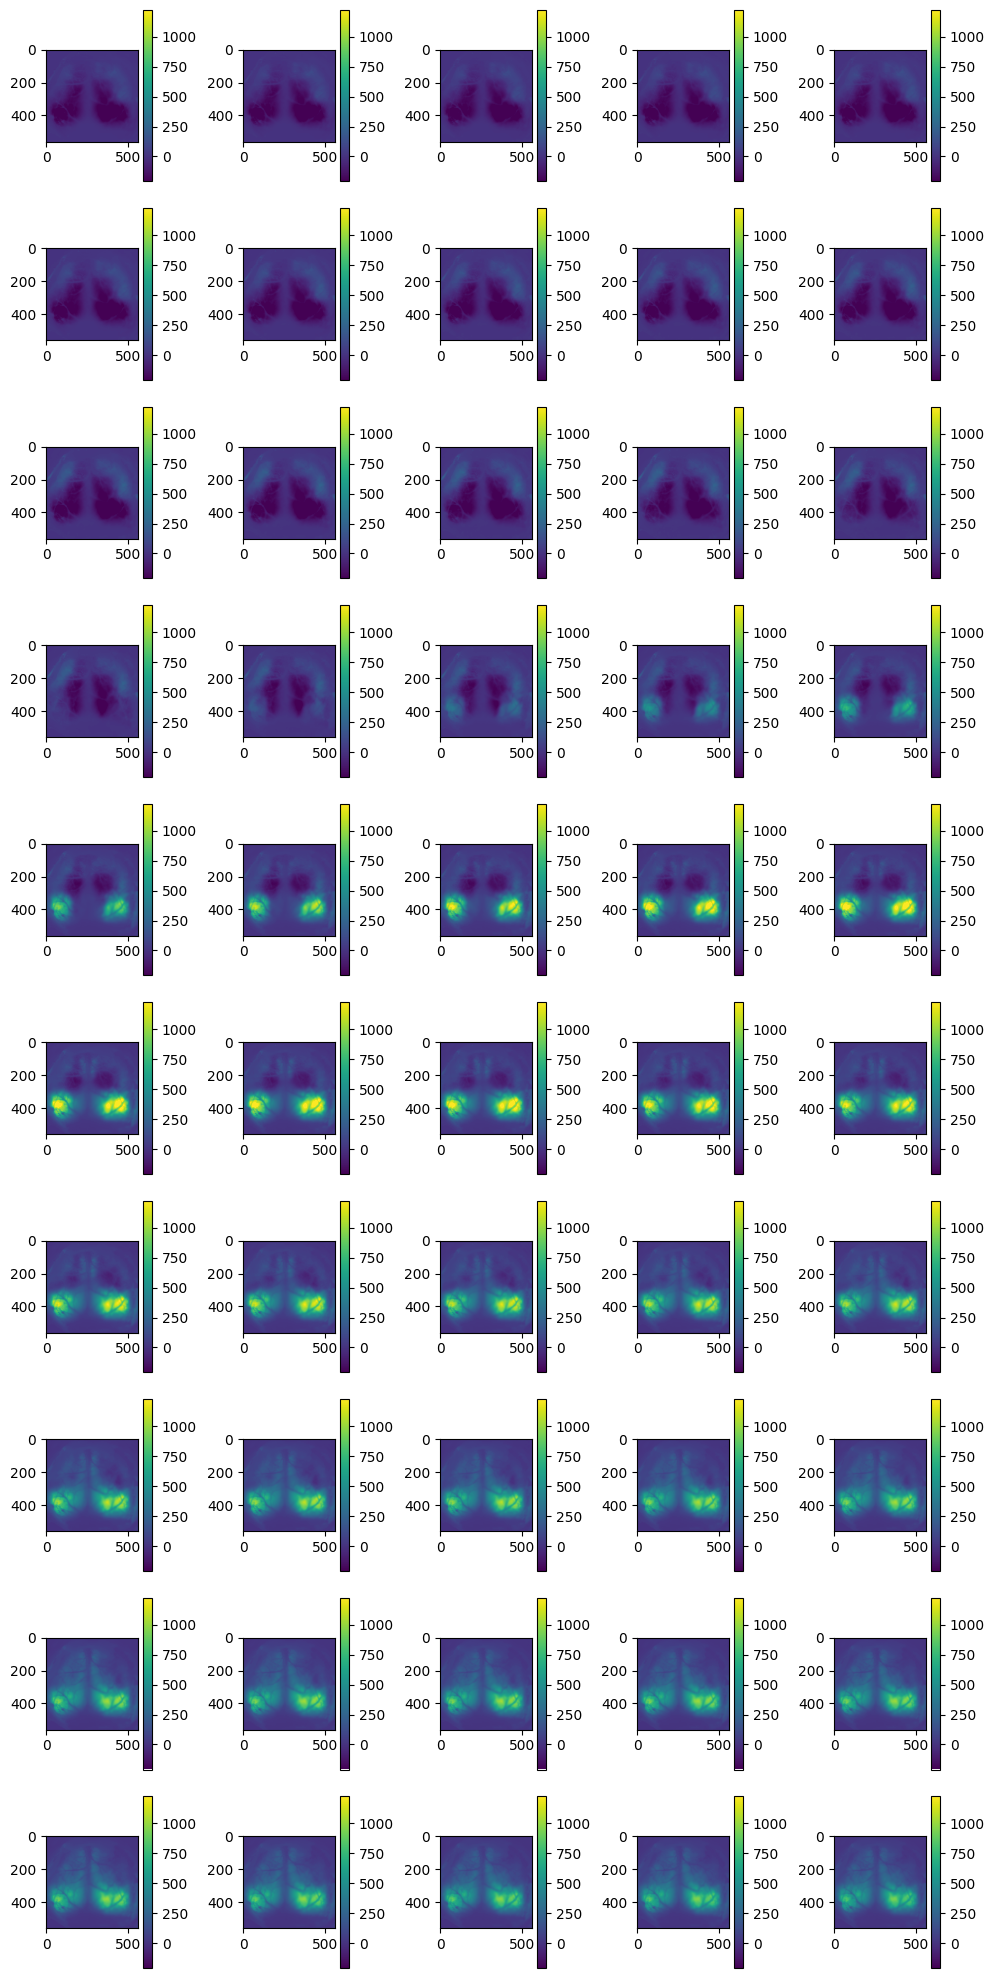

In [34]:
plot = wfData_new.plotBrain(10,5)

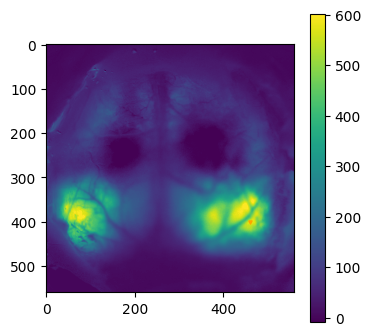

In [35]:
# avg cortical activity  
plot = wfData_new.plotBrain(1,1,True, figsizeCol=4, figsizeRow=4)
# plot pixel on this
plt.scatter([460],[400], c="orange", marker="v", s=5)
# nice 

In [36]:
# time 0 image data 
trial_time_data_0 = wfData_new.trial_timeFunc(-.1, .4, 100, True, 0)
trial_activity_data_0 = wfData_new.trial_activityFunc(trial_time_data_0)

video_0 = wfData_new.createVideo(trial_activity_data_0)
#plot_0 = wfData_new.plotBrain(10,5)

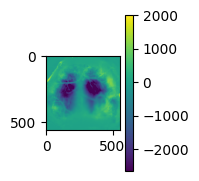

In [44]:
# single frame
plot = wfData_new.plotBrain(1,1,False,2,2)

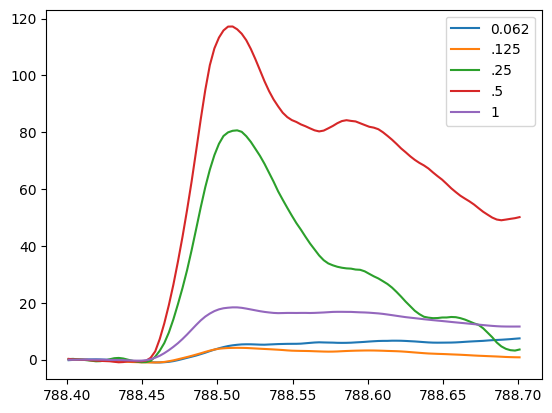

In [38]:
# contrast videos
videos = wfData_new.createContrastVideos(.1,.6,100)
colors = ['red', 'blue', 'orange', 'pink', 'purple']

videosCorr = []
for j in range(0,5):
    frame_raw = videos[j,330:350,400:430,:]
    frame_corr = wfData_new.corrections(frame_raw)
    plt.plot(trial_time_data_0, frame_corr)
    plt.legend(["0.062", ".125", '.25', '.5', '1'])

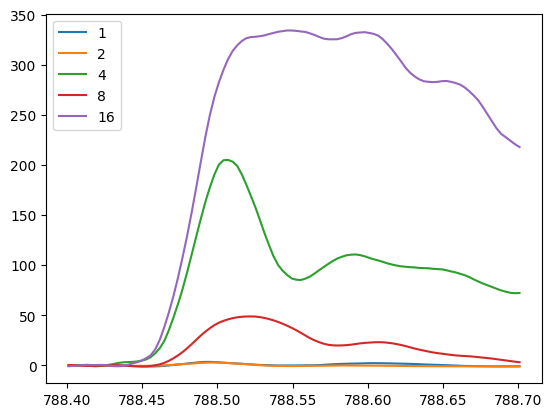

In [39]:
# duration videos 
videosDur = wfData_new.createDurationVideos(.1,.6,100)
colors = colors = ['red', 'blue', 'orange', 'pink', 'purple']
videosCorr = []
for j in range(0,5):
    frame_raw = videosDur[j,330:350,400:430,:]
    frame_corr = wfData_new.corrections(frame_raw)
    plt.plot(trial_time_data_0, frame_corr)
    plt.legend(["1",  "2",  "4",  "8", "16", "32", "64"])

In [41]:
# create new object and create contrasts/durations vids
wfDataCD = wfData(Path(r'Z:\Subjects\AL_0023\2023-05-15\1'), Path(r'Z:\Subjects\AL_0023\2023-05-15\3'))
videosCD = wfDataCD.createConDurVid(0.1,0.6,100,3)
timeScale = np.linspace(-0.1,0.6,100)

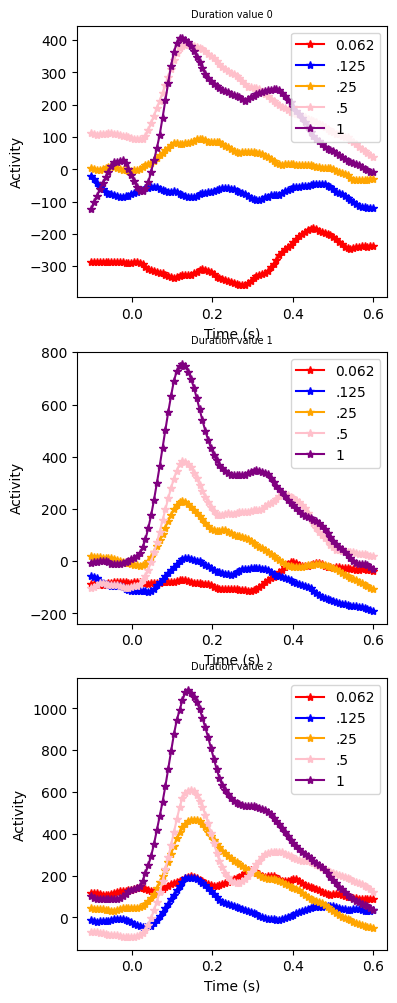

In [42]:
#plot without corrections
colors = ['red', 'blue', 'orange', 'pink', 'purple']
n_cols = 1
n_rows = 3
f = plt.figure(figsize=(n_cols*4, n_rows*4))
gs = mpl.gridspec.GridSpec(n_rows, n_cols)
for i in range(3):
    ax = plt.subplot(gs[i])
    for j in range(0,5):
        plt.plot(timeScale, videosCD[i,j,460,400], marker='*', c=colors[j])
    plt.legend(["0.062", ".125", '.25', '.5', '1'])
    plt.xlabel("Time (s)")
    plt.ylabel("Activity")
    plt.title("Duration value " + str(i), fontsize = 7)

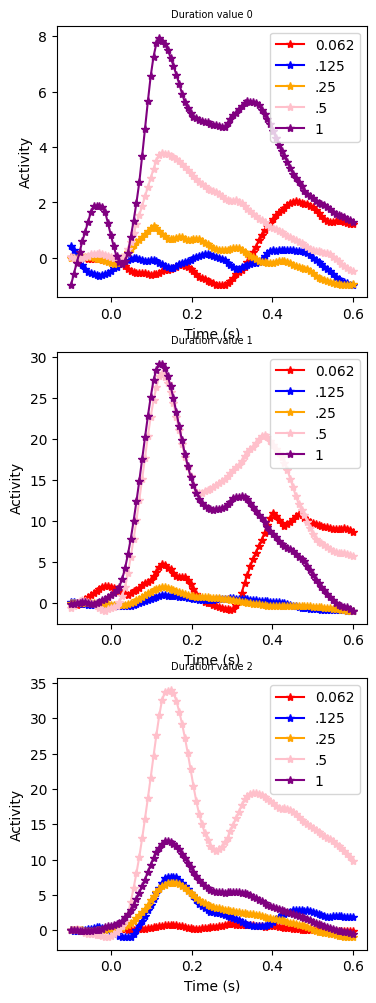

In [43]:
# plot with corrections 
n_cols = 1
n_rows = 3
f = plt.figure(figsize=(n_cols*4, n_rows*4))
gs = mpl.gridspec.GridSpec(n_rows, n_cols)
for i in range(3):
    ax = plt.subplot(gs[i])
    for j in range(0,5):
        frame_rawCD = videosCD[i,j,440:470,390:410,:]
        frame_corrCD = wfDataCD.corrections(frame_rawCD)
        plt.plot(timeScale, frame_corrCD, marker='*', c=colors[j])
    plt.legend(["0.062", ".125", '.25', '.5', '1'])
    plt.xlabel("Time (s)")
    plt.ylabel("Activity")
    plt.title("Duration value " + str(i), fontsize = 7)